In [1]:
import numpy as np
import pymanopt 
import pandas as pd
import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr

import seaborn as sns

from matplotlib import pyplot as plt


## Useful Functions

In [2]:
def outlier_gen(n_in: int, n_out: int, seed: int = 111111, n: int = 4, k: int = 2) -> list:
    '''
    Generate a dataset on Gr(k,n) with n_in inliers and n_out outliers.
    '''
    #reproducibility
    np.random.seed(seed)

    #generate a center point for inliers
    center = np.random.rand(n,k)*10
    center_rep = np.linalg.qr(center)[0][:,:k]

    #generate a center point for outliers
    center_o = np.random.rand(n,k)*10
    center_o_rep = np.linalg.qr(center_o)[0][:,:k]

   
    data_all = []
    #inlier data near inlier center
    for _ in range(n_in):
        Y_raw = center_rep + (np.random.rand(n,k)-.5)*.01
        Y = np.linalg.qr(Y_raw)[0][:,:k]
        data_all.append(Y)

    #outlier data near outlier center
    for _ in range(n_out):
        Y_raw = center_o_rep+ (np.random.rand(n,k)-.5)*.01
        Y = np.linalg.qr(Y_raw)[0][:,:k]
        data_all.append(Y)

    return data_all

In [3]:
#functions for comparing two sets of principal directions

def relDist(pcs: np.array, pcs_all: np.array) -> float:
    '''
    Relative distance between the euclidean distance matrices from pcs and pcs_all
    '''
    Dpca = np.linalg.norm(pcs.T[:, np.newaxis, :] - pcs.T, axis=-1)
    Dpca_all = np.linalg.norm(pcs_all.T[:, np.newaxis, :] - pcs_all.T, axis=-1)
    return np.linalg.norm(Dpca - Dpca_all)/np.linalg.norm(Dpca)

def angles(W: np.array, W_all: np.array) -> float:
    '''
    Mean principal angle between the subspaces spanned by W and Wall
    '''
    thetas = []
    k = W.shape[1]
    for i in range(k):
        cos = np.abs(W[:,[i]].T @ W_all[:,[i]])
        if cos > 1:
            cos = 1
        thetas = np.arccos(cos)
    thetas = np.array(thetas)
    return np.mean(thetas)

def reconstruction_error(t_data, W):
    '''
    euclidan reconstruction error
    '''
    return np.linalg.norm(t_data- W @ W.T @ t_data)**2

def reconstruction_error_diff(t_data, t_data_all, W, W_all):
    '''
    difference in reconstruction error
    '''
    re = reconstruction_error(t_data, W)
    re_all = reconstruction_error(t_data_all, W_all)
    return np.abs( re - re_all)/re 

def explained_variance(W, t_data):
    '''
    Explained variance of pcs
    '''
    return np.linalg.norm(W.T @ t_data)**2 

def explained_variance_diff(t_data, t_data_all, W, W_all):
    '''
    difference in explained variance of pcs
    '''
    ev = explained_variance(W, t_data) 
    ev_all = explained_variance( W_all,t_data_all)
    return np.abs(ev- ev_all)/ev 

def evaluate(W, W_all, pcs, pcs_all, t_data, t_data_all):
    '''
    compute relative distance, mean principal angles and explained variance difference between two methods
    '''
    D_stat = relDist(pcs, pcs_all)
    angle_stat = angles(W, W_all)
    ev_diff = explained_variance_diff(t_data, t_data_all, W, W_all)
    return D_stat, angle_stat, ev_diff


## Experiments

In [4]:

n = 4
k = 2

manifold = pymanopt.manifolds.grassmann.Grassmann(n,k)

In [5]:
data = outlier_gen(100, 20)

In [6]:
fl_types = [[1,2,3,4], [2,3,4], [1,2,4], [1,3,4], [3,4], [1,4], [2,4], [4] ]

In [9]:
base_fres = {}

for pca_type in ['wpca', 'rpca', 'dpcp']:
# for pca_type in ['wpca']:
    for fl_type in fl_types:
        

        print('doing ' + pca_type+str(fl_type))
        print('...')
        
        #fPCA
        data_fpca = [d.flatten() for d in data]
        if pca_type == 'dpcp':
            data_fpca = np.vstack([x/np.linalg.norm(x) for x in data_fpca]).T
        else:
            data_fpca = fdr.mean_center(data_fpca)


        W = fdr.flag_robust_pca(data_fpca,
                                fl_type, 
                                pca_type,
                                max_iters = 200,
                                init= 'rand',
                                verbose = False,
                                return_all = False)
        pcs = W.T @ data_fpca

        base_fpca = [data_fpca, W, pcs]


        #t-fPCA
        [W, _, _], t_data = fdr.flag_robust_tpca(   manifold,
                                                    data,
                                                    fl_type, 
                                                    pca_type,
                                                    init= 'rand',
                                                    max_iters = 200,
                                                    return_ts= True,
                                                    verbose = False,
                                                    eps = 1e-9)
        pgs = W.T @ t_data

        base_tfpca = [t_data, W, pgs]

        base_fres[pca_type+str(fl_type)] = [base_fpca, base_tfpca]

doing wpca[1, 2, 3, 4]
...
doing wpca[2, 3, 4]
...
doing wpca[1, 2, 4]
...
doing wpca[1, 3, 4]
...
doing wpca[3, 4]
...
doing wpca[1, 4]
...
doing wpca[2, 4]
...
doing wpca[4]
...
doing rpca[1, 2, 3, 4]
...
doing rpca[2, 3, 4]
...
doing rpca[1, 2, 4]
...
doing rpca[1, 3, 4]
...
doing rpca[3, 4]
...
doing rpca[1, 4]
...
doing rpca[2, 4]
...
doing rpca[4]
...
doing dpcp[1, 2, 3, 4]
...
doing dpcp[2, 3, 4]
...
doing dpcp[1, 2, 4]
...
doing dpcp[1, 3, 4]
...
doing dpcp[3, 4]
...
doing dpcp[1, 4]
...
doing dpcp[2, 4]
...
doing dpcp[4]
...


In [10]:
results = pd.DataFrame(columns = ['Algorithm', 'D', 'T', 'V','FlagType'])

for tkey, pca_type in zip(['WPCA', 'RPCA', 'DPCP'],['wpca', 'rpca', 'dpcp']):
# for tkey, pca_type in zip(['WPCA'],['wpca']):
    for fl_type in fl_types[1:]:

        base_euc_res, base_man_res = base_fres[pca_type+str([1,2,3,4])]
        euc_res, man_res = base_fres[pca_type+str(fl_type)]

        base_t_data, base_W, base_pcs = base_euc_res
        t_data, W, pcs = euc_res
        d,t,v = evaluate(W, base_W, pcs, base_pcs, t_data, base_t_data)
        res = pd.DataFrame(columns = results.columns,
                           data = [[f'f{tkey}', d, t, v, fl_type]])
        results = pd.concat([results,res])

        base_t_data, base_W, base_pcs = base_man_res
        t_data, W, pcs = man_res
        d,t,v = evaluate(W, base_W, pcs, base_pcs, t_data, base_t_data)
        res = pd.DataFrame(columns = results.columns,
                           data = [[f'Tf{tkey}', d, t, v, fl_type]])
        results = pd.concat([results,res])

In [11]:
results.to_csv('../Results/flag_type.csv')

## Make Plots

In [12]:
results = pd.read_csv('../Results/flag_type.csv', index_col = 0)

results.head()

,Algorithm,D,T,V,FlagType
0,fWPCA,3.723729e-04,0.152343,3.337842e-07,"[2, 3, 4]"
0,TfWPCA,2.753677e-16,0.209707,4.411628e-16,"[2, 3, 4]"
0,fWPCA,1.883622e-05,0.037816,1.871301e-08,"[1, 2, 4]"
0,TfWPCA,2.131113e-16,0.083183,7.352713e-16,"[1, 2, 4]"
0,fWPCA,6.805975e-05,0.157792,1.601809e-08,"[1, 3, 4]"


In [13]:
idx = (results['FlagType'] == str([2,3,4])) + (results['FlagType'] == str([1,2,4])) + (results['FlagType'] == str([1,3,4]))
t1= np.mean(results[idx]['T'])
idx = (results['FlagType'] == str([1,4])) + (results['FlagType'] == str([2,4])) + (results['FlagType'] == str([3,4]))
t2= np.mean(results[idx]['T'])
idx = (results['FlagType'] == str([4]))
t3= np.mean(results[idx]['T'])

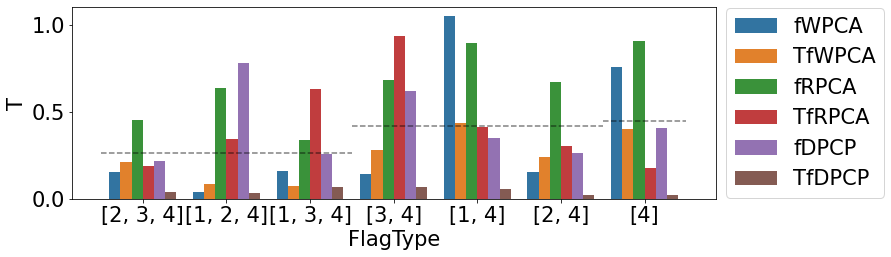

In [15]:
plt.rcParams.update({'font.size': 21})
plt.figure(figsize = (13,4))
sns.barplot(data= results, x= 'FlagType', y= 'T', hue = 'Algorithm')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(y = t1, xmin=-.5, xmax = 2.5, color= 'k', linestyle = 'dashed', alpha = .5)
plt.hlines(y = t2, xmin=2.5, xmax = 5.5, color= 'k', linestyle = 'dashed', alpha = .5)
plt.hlines(y = t3, xmin=5.5, xmax = 6.5, color= 'k', linestyle = 'dashed', alpha = .5)
plt.tight_layout()
plt.savefig('../Results/flag_type_test.pdf', bbox_inches = 'tight')